In [1]:
import time
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

2023-02-05 23:41:05.859650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Optimizer 1: $f(\mathbf{x}) = \mathbf{Ax} - \mathbf{b}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:


A = np.array([[2,1,3],[2,6,8],[6,8,18]]).astype(np.float32) # 3 x 3
b = np.array([[1],[3],[5]]).astype(np.float32) # 3 x 1

x = np.random.uniform(-1.0,1.0,size=(3,1)) # 3 x 1
x_memo = np.copy(x)

# Solution
y = np.dot(np.linalg.inv(A), b)

def F(x):
  return np.dot(A,x) - b


# definition of loss function (MSE of F(x))
def L(x):
  delta = F(x) - y
  return (np.dot(delta.T, delta) / (2 * y.shape[0])).flatten().item()


# definition of gradient
def g(x):
  return np.dot(A.T, F(x))

In [4]:
EPSILON = 1e-7
MAX_ITERATIONS = 1000

def update(x, delta_theta):
  x += delta_theta

def get_accuracy(x):
  prediction = F(x)

  # no accuracy for regression problem
  if len(prediction) == 1:
    return -1

  prediction = np.argmax(prediction, axis=1)
  label = np.argmax(y, axis=1)
  accuracy = np.divide(np.sum(prediction==label), label.shape[0])
  return np.around(accuracy, decimals=3)

In [5]:
def GD(x, alpha, verbose=False):
  """Implementation of gradient descent loop."""
  i = 0
  history = []
  accuracy = []
  while True:
    update(x, -alpha * g(x))
    loss = L(x)
    history.append(loss)
    accuracy.append(get_accuracy(x))
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < EPSILON or i == MAX_ITERATIONS:
      break

  return x, history, accuracy

In [6]:
def Momentum(x, alpha, beta=0.9, verbose=False):
  i = 0
  history = []
  accuracy = []
  prev_vT = 0
  while True:
    vT = beta * prev_vT + (1 - beta) * g(x)
    update(x, -alpha * vT)
    loss = L(x)
    history.append(loss)
    accuracy.append(get_accuracy(x))
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < EPSILON or i == MAX_ITERATIONS:
      break
    prev_vT = vT

  return x, history, accuracy

In [7]:
def Adadelta(x, beta=0.95, verbose=False):
  epsilon = 1e-6
  expected_g_square = 0
  expected_delta_theta_square = 0
  rms_theta = 0
  i = 0
  history = []
  accuracy = []

  while True:
    gradient = g(x)
    expected_g_square = (beta * expected_g_square) + (1 - beta) *  np.square(gradient)

    delta_theta = -(np.sqrt(expected_delta_theta_square + epsilon) / \
                   np.sqrt(expected_g_square + epsilon)) * gradient
    update(x, delta_theta)

    loss = L(x)
    history.append(loss)
    accuracy.append(get_accuracy(x))
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < EPSILON or i == MAX_ITERATIONS:
      break
    
    expected_delta_theta_square = (beta * expected_delta_theta_square) + \
        (1 - beta) * np.square(delta_theta)

  return x, history, accuracy

In [8]:
def Adam(x, alpha, beta1=0.9, beta2=0.999, verbose=False):
  epsilon = 1e-8
  m_t = 0
  v_t = 0
  i = 0
  history = []
  accuracy = []

  while True:
    t = i + 1
    gradient = g(x)
    m_t = beta1 * m_t + (1 - beta1) * gradient
    v_t = beta2 * v_t + (1 - beta2) * np.square(gradient)

    m_t_hat = m_t / (1 - beta1 ** t)
    v_t_hat = v_t / (1 - beta2 ** t)
    
    update(x, -alpha * m_t_hat / (np.sqrt(v_t_hat) + epsilon))

    loss = L(x)
    history.append(loss)
    accuracy.append(get_accuracy(x))
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < EPSILON or i == MAX_ITERATIONS:
      break

  return x, history, accuracy

In [9]:
def AdamWithWarmup(x, alpha, beta1=0.9, beta2=0.999, warmup_steps=1000, verbose=False):
  epsilon = 1e-8
  m_t = 0
  v_t = 0
  i = 0
  history = []
  accuracy = []

  while True:
    t = i + 1
    warmup_rate = t / warmup_steps
    learning_rate = alpha * min(1, warmup_rate)
    
    gradient = g(x)
    m_t = beta1 * m_t + (1 - beta1) * gradient
    v_t = beta2 * v_t + (1 - beta2) * np.square(gradient)

    m_t_hat = m_t / (1 - beta1 ** t)
    v_t_hat = v_t / (1 - beta2 ** t)
    
    update(x, -learning_rate * m_t_hat / (np.sqrt(v_t_hat) + epsilon))

    loss = L(x)
    history.append(loss)
    accuracy.append(get_accuracy(x))
    if verbose:
      print(i, loss, x.flatten())
    i += 1
    if loss < EPSILON or i == MAX_ITERATIONS:
      break

  return x, history, accuracy

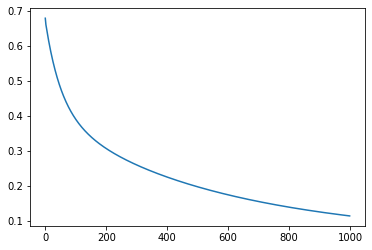

In [10]:
x = np.copy(x_memo)
x, history, _ = GD(x, alpha=0.002, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

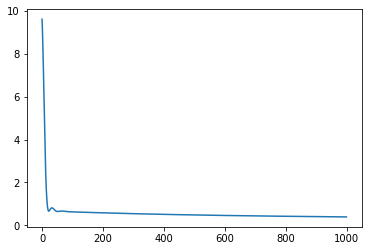

In [11]:
x = np.copy(x_memo)
x, history, _ = Momentum(x, alpha=0.0002, beta=0.9, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

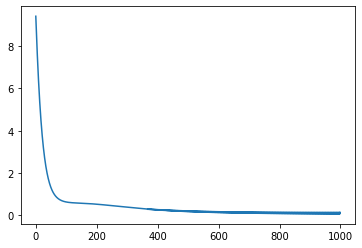

In [12]:
x = np.copy(x_memo)
x, history, _ = Adadelta(x, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

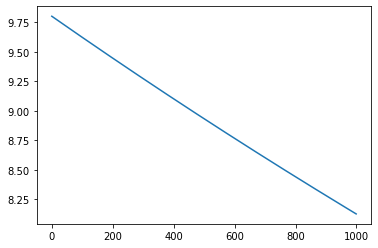

In [13]:
x = np.copy(x_memo)
x, history, _ = Adam(x, alpha=2e-5, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

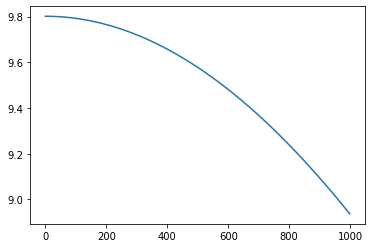

In [14]:
x = np.copy(x_memo)
x, history, _ = AdamWithWarmup(x, alpha=2e-5, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

In [15]:
# For Ax = b, the solution is (A**-1 * b).T
print("Solution is: ", np.dot(np.linalg.inv(A),b).T)

Solution is:  [[0.30000007 0.39999986 0.        ]]


# Section 2: $f(\mathbf{x}) = (1-x_{0})^2 + 100 \times (x_{1} - (x_{0})^2)^2 $

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.uniform(-1.0,1.0,size=(2,1))
x_memo = np.copy(x)
y = 0

def F(x):
  return np.power(1-x[0],2) + 100.0*np.power(x[1] - np.power(x[0],2),2)


# definition of loss function (MSE of F(x))
def L(x):
  delta = F(x) - y
  return (np.square(delta) / (2 * x.shape[0])).flatten().item()


# definition of gradient
def g(x):
  return np.array([
    -2*(1-x[0]) - 100.0*4*x[0]*(x[1] - np.power(x[0],2)),
    100.0*2*(x[1] - np.power(x[0],2))
  ])

In [17]:
EPSILON = 1e-7

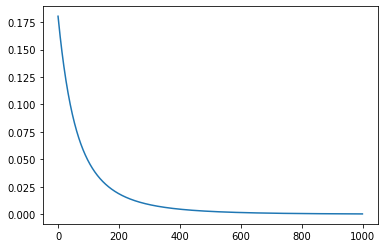

In [18]:
x = np.copy(x_memo)
x, history, _ = GD(x, 0.002, False)
plt.cla()
plt.plot(history)
plt.show()

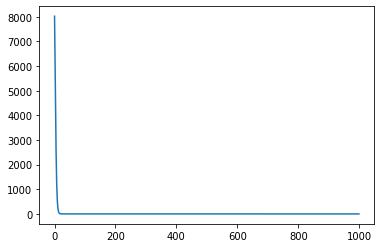

In [19]:
x = np.copy(x_memo)
x, history, _ = Momentum(x, alpha=0.0002, beta=0.9, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

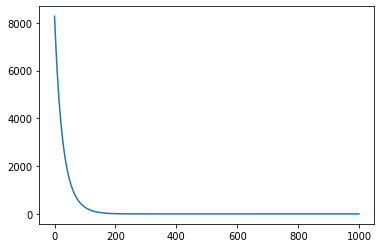

In [20]:
x = np.copy(x_memo)
x, history, _ = Adadelta(x, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

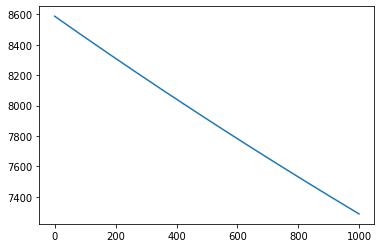

In [21]:
x = np.copy(x_memo)
x, history, _ = Adam(x, alpha=2e-5, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

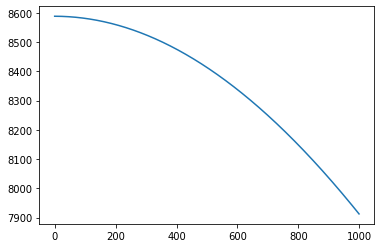

In [22]:
x = np.copy(x_memo)
x, history, _ = AdamWithWarmup(x, alpha=2e-5, verbose=False)
plt.cla()
plt.plot(history)
plt.show()

In [23]:
# For Ax = b, the solution is (A**-1 * b).T
print("Solution is: ", np.dot(np.linalg.inv(A),b).T)

Solution is:  [[0.30000007 0.39999986 0.        ]]
